In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [4]:
import numpy as np
import pandas as pd

#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import acf, pacf, q_stat, adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional,  RepeatVector,Flatten
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

import pywt

In [5]:
import os

# Define the log directory for TensorBoard
log_dir = "logs/fit"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Setup TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [6]:
# Helper Function to fetch historical stock data
import yfinance as yf
def get_stock_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        return f"Error fetching data: {e}"
    

In [7]:
ticker_symbol = "BNII.JK"  #  Apple Inc. 
start_date = "2010-01-01"
end_date = "2024-10-01"
stock_data = get_stock_data(ticker_symbol, start_date, end_date)
stock_data.asfreq('B').index  # set index frequency to business daliy
stock_data.info()


[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3638 entries, 2010-01-04 to 2024-09-30
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, BNII.JK)  3638 non-null   float64
 1   (Close, BNII.JK)      3638 non-null   float64
 2   (High, BNII.JK)       3638 non-null   float64
 3   (Low, BNII.JK)        3638 non-null   float64
 4   (Open, BNII.JK)       3638 non-null   float64
 5   (Volume, BNII.JK)     3638 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 328.0 KB


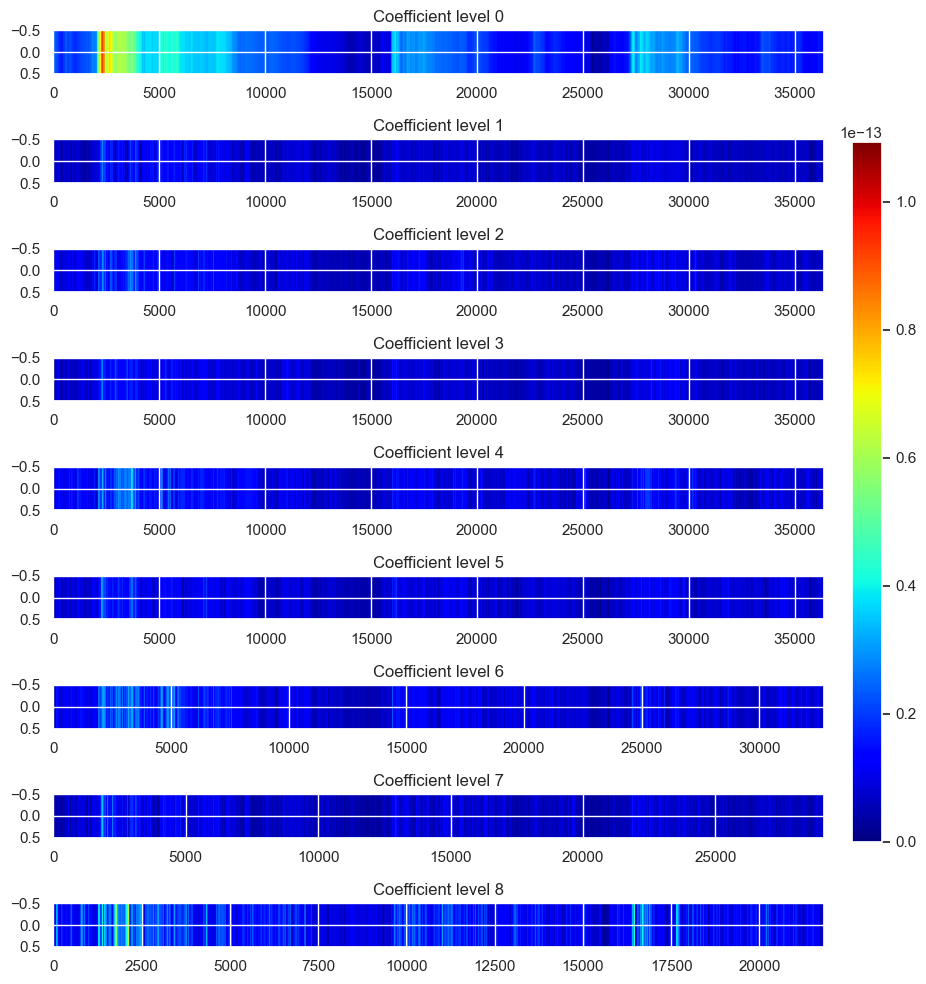

In [9]:
import pywt

# Perform the Discrete Wavelet Transform with 'dbN'
wavelet = pywt.Wavelet('db6')
coeffs = pywt.wavedec(stock_data['Close'], wavelet, level=8)

# Plotting the Wavelet Coefficients using imshow
fig, axes = plt.subplots(len(coeffs), 1, figsize=(10, 10))

for i, ax in enumerate(axes):
    im = ax.imshow(np.abs(coeffs[i].reshape(1, -1)), aspect='auto', cmap='jet')
    ax.set_title(f'Coefficient level {i}')

# Add a single colorbar on the far right
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.85, 1])
#plt.show()

# Save the figure
plt.savefig('db6.jpg')


In [11]:
# Prepare Data for LSTM
df = stock_data.copy()
wavelet = pywt.Wavelet('db6')

# Apply wavelet transform
def wavelet_transform(data, lvl=8):
    coeff = pywt.wavedec(data, wavelet, mode='symmetric', level=lvl)
    return coeff

# Inverse wavelet transform
def inverse_wavelet_transform(coeff):
    # Remove last 3 finer details
    for i in range(3):
        coeff[i+5] = np.zeros(coeff[i+5].shape)
    return pywt.waverec(coeff, wavelet, mode='symmetric')

# Prepare data
close_prices = df['Close'].values
wavelet_coeff = wavelet_transform(close_prices)
reconstructed_data = inverse_wavelet_transform(wavelet_coeff)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(reconstructed_data.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential([
    Bidirectional(LSTM(units=256, return_sequences=True, input_shape=(seq_length, 1))),
    Dropout(0.3), 
    Bidirectional(LSTM(units=128, return_sequences=False)),
    Dropout(0.3), 
    RepeatVector(seq_length),  # Number of future timesteps
    Dropout(0.2), 
    Dense(units=64, activation='relu'),
    Dense(units=32),
    Flatten(),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Create TensorBoard log directory
log_dir = "logs/fit"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Setup TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with TensorBoard callback
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[early_stopping, tensorboard_callback])

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate error metrics
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mape = mean_absolute_percentage_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

#print(f"Train MAE: {train_mae}, Train MSE: {train_mse}, Train RMSE: {train_rmse}, Train MAPE: {train_mape}, Train R2: {train_r2}")
#print(f"Test MAE: {test_mae}, Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test MAPE: {test_mape}, Test R2: {test_r2}")

Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - loss: 0.0054 - mae: 0.0433 - val_loss: 4.2791e-04 - val_mae: 0.0139
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 6.8480e-04 - mae: 0.0168 - val_loss: 2.9959e-04 - val_mae: 0.0126
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 6.4757e-04 - mae: 0.0170 - val_loss: 4.5097e-04 - val_mae: 0.0180
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 3.8430e-04 - mae: 0.0131 - val_loss: 2.8839e-04 - val_mae: 0.0134
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 3.6859e-04 - mae: 0.0127 - val_loss: 3.0763e-04 - val_mae: 0.0152
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 3.6858e-04 - mae: 0.0129 - val_loss: 2.9104e-04 - val_mae: 0.0128
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 3.7094e-04 - mae: 0.0128 - val_loss: 1.2381e-04 - val_mae: 0.0073
Epoch 8/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 3.4513e-04 - mae: 0.0117 - val_loss: 1